# Transfer Learning in Keras

In this notebook, we shall experiment with transfer learning  from the pretrained model VGG16 which is trained on imagenet data to perform classification task on cats and dogs dataset. 

#### Load dependencies

In [1]:
import keras
import os, shutil

In [3]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import optimizers

In [4]:
keras.__version__

'2.7.0'

#### Load the pre-trained VGG16 model


The following code removes the top prediction layers of VGG16 trained on imagenet. Original input dmensions are retained as 224x224x3. These dimensions are compatible with cats-dogs dataset. 
No pooling is required.

In [5]:
vgg16 = VGG16(include_top=False,
              weights='imagenet',
              input_shape=(224,224,3),
              pooling=None)

58900480/58889256 [==============================] - 1s 0us/step


#### Freeze all the layers in the base VGGNet16 model

In [6]:
for layer in vgg16.layers:
    layer.trainable = False

#### Add custom classification layers

In [8]:
import keras
from tensorflow.keras import optimizers
# Instantiate the sequential model and add the VGG16 model: 
model = keras.models.Sequential()
model.add(vgg16)
# Add the custom layers atop the VGG19 model: 
model.add(Flatten(name='flattened'))
model.add(Dropout(0.5, name='dropout1'))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3, name='dropout2'))
model.add(Dense(1, activation='sigmoid', name='predictions'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])




/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flattened (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout1 (Dropout)           (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout2 (Dropout)           (None, 512)               0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 513       
Total params: 27,560,769
Trainable params: 12,846,081
Non-trainable params: 14,714,688
_________________________________

In the above note that all vgg16 model parameters are non-trainable.

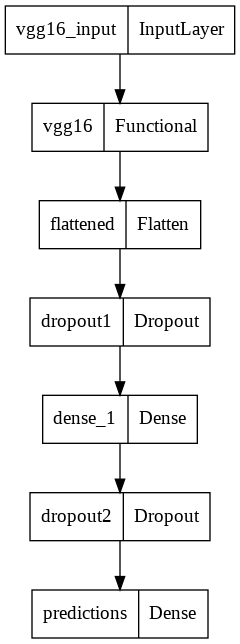

In [9]:
plot_model(model)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

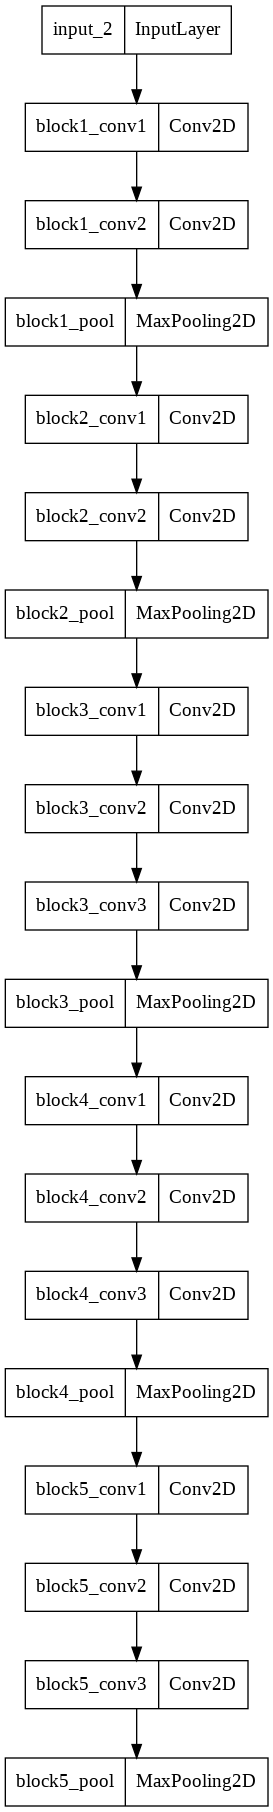

In [10]:
# This code is to see the model architecture inside VGG16
base_model = VGG16(weights='imagenet', include_top = False)
base_model.summary()
plot_model(base_model)
# model_VGG16 = models.Model(inputs=base_model.input, outputs=base_model.get_layer('flatten').output)

#### Prepare the data for training

# Using Cats dataset

In [11]:
# mount drive first
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# Provide path to the dataset
base_dir = '/content/drive/MyDrive/DataGenerator/cats_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [18]:
test_dir

'/content/drive/MyDrive/DataGenerator/cats_dogs_small/test'

In [19]:
# Directories for our training,
# validation and test splits

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')

In [20]:
# Verify path
train_cats_dir

'/content/drive/MyDrive/DataGenerator/cats_dogs_small/train/cats'

In [21]:
print('total training cat images:', len(os.listdir(train_cats_dir)))

total training cat images: 1000


References for data generation: 
1. https://keras.io/api/preprocessing/image/
2. https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720


In [22]:
# Preparing the data
# Batch size depends on the datset size. 
# In this example there are 2000 image in training set and 1000 in test set.
# Both are divisible by 20. Hence batch size is chosen as 20

from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory (train_dir, )
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 224x224
        target_size=(224, 224),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 1010 images belonging to 2 classes.


In [23]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 224, 224, 3)
labels batch shape: (20,)


In [24]:
# steps_per_epoch is based on the number of batches available in the training dataset
# validation_steps is based on the number of batches in the validation dataset

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 604s 6s/step - loss: 0.5334 - accuracy: 0.7645 - val_loss: 0.2683 - val_accuracy: 0.8810
Epoch 2/30
100/100 [==============================] - 32s 324ms/step - loss: 0.3067 - accuracy: 0.8670 - val_loss: 0.2160 - val_accuracy: 0.9130
Epoch 3/30
100/100 [==============================] - 32s 324ms/step - loss: 0.2518 - accuracy: 0.8900 - val_loss: 0.3017 - val_accuracy: 0.8740
Epoch 4/30
100/100 [==============================] - 32s 325ms/step - loss: 0.2024 - accuracy: 0.9195 - val_loss: 0.2230 - val_accuracy: 0.9070
Epoch 5/30
100/100 [==============================] - 32s 325ms/step - loss: 0.1725 - accuracy: 0.9275 - val_loss: 0.2271 - val_accuracy: 0.9090
Epoch 6/30
100/100 [==============================] - 32s 324ms/step - loss: 0.1771 - accuracy: 0.9315 - val_loss: 0.2426 - val_accuracy: 0.9100
Epoch 7/30
100/100 [==============================] - 32s 324ms/step - loss: 0.1221 - accuracy: 0.9535 - val_loss: 0.2291 - val_accu

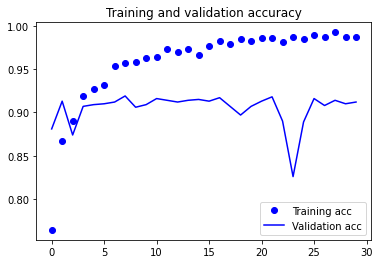

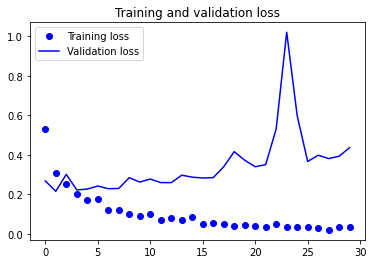

In [25]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
model.save('transfer_learning_VGG16_cats.h5')

from google.colab import files
files.download('transfer_learning_VGG16_cats.h5')
# model.save('/content/drive/My Drive/Colab Notebooks/Teaching/transfer_learning_VGG16_cats.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>